## Is it a bird?

In [4]:
!jupyter nbconvert --to script weather.ipynb

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-nbconvert` not found.


In [ ]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
!pip install duckduckgo_search
! [ -e /content ] && pip install -Uqq fastbook

import os
from fastai.vision.all import *
import fastbook
from fastbook import *
from fastai.vision.widgets import *

!pip install voila
!jupyter serverextension enable --sys-prefix voila

fastbook.setup_book()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
      voila 0.4.0 OK


In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

![image.png](attachment:a0483178-c30e-4fdd-b2c2-349e130ab260.png)

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "bird photos"
1. Use DuckDuckGo to search for images of "forest photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

## Step 1: Download images of birds and non-birds

In [ ]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=60):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [ ]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('weather photo', max_images=1)
urls[0]

Searching for 'weather photo'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


'https://images2.minutemediacdn.com/image/upload/c_fill,g_auto,h_1248,w_2220/v1555433324/shape/mentalfloss/weather_header.jpg?itok=IG9pRo40'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

...and then download a URL and take a look at it:

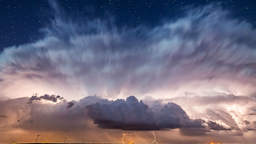

In [ ]:
from fastdownload import download_url
dest = 'weather.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [ ]:
queries = ['rainy weather', 'cloudy weather', 'clear weather']
path = Path('bird_or_not')
from time import sleep

for q in queries:
    dest = (path/q)
    dest.mkdir(exist_ok=True, parents=True)

    download_images(dest, urls=search_images(q + " daytime photos"))
    sleep(10)
    download_images(dest, urls=search_images(q + " night time photos"))
    #sleep(10)
    #download_images(dest, urls=search_images(f'{o} pants photo'))
    #sleep(10)
    #download_images(dest, urls=search_images(f'{o} hat photo'))
    #sleep(10)


Searching for 'rainy weather daytime photos'
Searching for 'rainy weather night time photos'
Searching for 'cloudy weather daytime photos'
Searching for 'cloudy weather night time photos'
Searching for 'clear weather daytime photos'
Searching for 'clear weather night time photos'


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

20

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

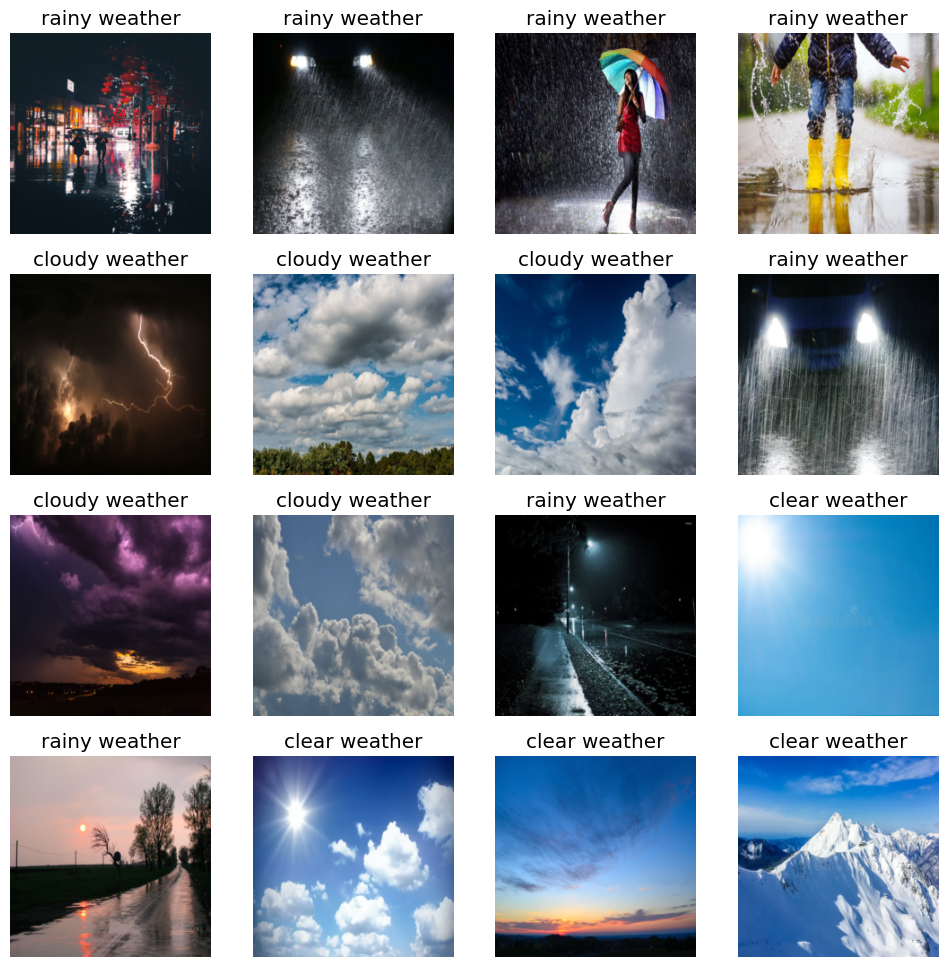

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(224, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=16)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files,

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.254224,0.781209,0.326087,01:04


epoch,train_loss,valid_loss,error_rate,time
0,0.490483,0.314990,0.097826,01:02
1,0.344219,0.257830,0.086957,01:02


In [ ]:

#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
# delete and recategorize some images by hand
#print(cleaner)
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

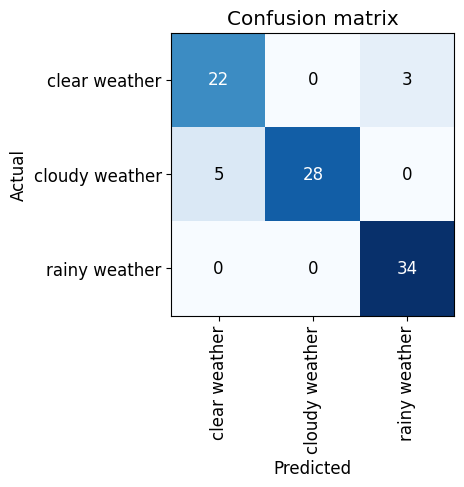

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [ ]:
download_url(search_images('beautiful sky', max_images=1)[0], 'rain.jpg', show_progress=False)
Image.open('rain.jpg')
category,_,probs = learn.predict(PILImage.create('rain.jpg'))
print(probs)
print(f"This is a picture of {category}")

Searching for 'beautiful sky'


tensor([9.9746e-01, 9.1945e-04, 1.6227e-03])
This is a picture of clear weather


In [27]:
!jupyter nbconvert --to script weather.ipynb

[NbConvertApp] WARNING | pattern 'weather.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Exe

In [ ]:
learn_inf = load_learner('export.pkl')

Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

In [ ]:
#hide_output
#interp = ClassificationInterpretation.from_learner(learn)
#interp.plot_confusion_matrix()

cleaner = ImageClassifierCleaner(learn)
cleaner


NameError: ignored

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
btn_upload = SimpleNamespace(data="rain.jpg")
img = PILImage.create(btn_upload.data)
img

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(256,256))
out_pl

Output()

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)
label = widgets.Label()
label.value = f'Prediction: {pred}. Probability: {probs[pred_idx]}'
print(label)

Label(value='Prediction: clear weather. Probability: 0.47030824422836304')


In [ ]:
classify_button = widgets.Button(Description="Classify")
classify_button

Button(style=ButtonStyle())

In [ ]:
def on_click_classify(change):
    print(btn_upload.data)
    img = PILImage.create(btn_upload.data)
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(256,256))
    pred,pred_idx,probs = learn_inf.predict(img)
    label.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

classify_button.on_click(on_click_classify)
upload_button = widgets.FileUpload()
VBox([widgets.Label('Select an image of the weather.'),
      upload_button, classify_button, out_pl, label])


rain.jpg


rain.jpg


rain.jpg


rain.jpg
